### **Section 1: Data Cleaning & Wrangling**

#### Objectives
Transform raw, messy e-commerce data into analysis-ready format while handling data quality issues and creating meaningful features.

In [ ]:
%pip install -r requirements.txt

In [1]:
# imports
%matplotlib inline
import os
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from typing import Self
import dask.dataframe as dd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from scipy.stats import gaussian_kde


## **Task 1.1: Data Quality Assessment**
---




In [ ]:
# transforming the data from csv format to parquet due to memory issues
df = dd.read_csv("../Data/Raw/2019-Nov.csv")
df.to_parquet("../Data/Raw/2019_nov_prqt")

In [2]:
df = dd.read_csv("../Data/Raw/2019-Oct.csv")
df.to_parquet("../Data/Raw/2019_oct_prqt")

---


In [4]:
class DataRawAnalysis:
    """A comprehensive data analysis class for processing large e-commerce datasets with Polars.
    
    This class specializes in analyzing data quality issues in e-commerce data, with particular
    focus on missing values distribution across various fields including user sessions, brand 
    information, and pricing data. It leverages Polars' lazy evaluation for memory-efficient
    processing of large-scale datasets that exceed memory limits.
    
    Key Analysis Capabilities:
    - Overall data quality statistics (null counts, percentages)
    - User session missingness analysis
    - Hierarchical analysis of missing brand information across category levels
    - Correlation analysis between missing price data and event types
    - Memory-efficient processing of large datasets using lazy evaluation
    
    Attributes:
        datapath (str): Path to the parquet dataset directory or file
        totalRows (int): Total number of rows in the dataset
        totalUserSessionNulls (int): Total number of rows with missing user_session values
        nullPercentageAny (float): Percentage of rows with missing user_session values
        highestCatWithNulls (str): Category code with the highest number of missing brand values
        lazyDf (pl.LazyFrame): The lazy DataFrame for analysis
    """
    
    def __init__(self, datapath: str) -> None:
        """Initializes the DataRawAnalysis instance and loads the dataset.
        
        Args:
            datapath: Path to the parquet dataset directory or file.
        
        Raises:
            Exception: If the parquet file cannot be loaded or processed.
        """
        self.datapath = datapath
        self.totalUserSessionNulls = 0
        self.totalRows = 0
        self.nullPercentageAny = 0.0
        
        try:
            self.lazyDf = pl.scan_parquet(datapath)
            self._optimizeDataTypes()
       
        except Exception as e:
            print(f"Error initializing the raw data analysis: {e}")
            raise
    
    def _optimizeDataTypes(self) -> Self:
        """Optimizes column data types for memory efficiency and performance.
        
        Analyzes integer columns and downcasts them to the smallest appropriate
        integer type (Int8, Int16, Int32) based on their maximum values. Converts
        object columns to categorical for better memory usage and performance.
        
        Returns:
            Self: Returns the instance for method chaining.
        """
        int64Cols = []
        objectCols = []
        schema = self.lazyDf.collect_schema()
        columns = schema.names()

        for column in columns:
            if schema[column] == pl.Int64:
                int64Cols.append(column)
            elif schema[column] == pl.Object:
                objectCols.append(column)


        # Compute max for all int64 columns once
        int64MaxVals = (
            self.lazyDf
            .select([pl.col(c).max().alias(f"{c}_max") for c in int64Cols])
            .collect()
        )

        # Build expressions for casting
        cast_exprs = []
        for column in int64Cols:
            max_val = int64MaxVals[f"{column}_max"][0]  # scalar
            if max_val <= 127:
                cast_exprs.append(pl.col(column).cast(pl.Int8))
            elif max_val <= 32767:
                cast_exprs.append(pl.col(column).cast(pl.Int16))
            elif max_val <= 2147483647:
                cast_exprs.append(pl.col(column).cast(pl.Int32))

        # Handle object cols (if any)
        for column in objectCols:
            cast_exprs.append(pl.col(column).cast(pl.Categorical))

        # Apply all casts in one go
        if cast_exprs:
            self.lazyDf = self.lazyDf.with_columns(cast_exprs)

        return self

    def calculateStatistics(self) -> None:
        """Calculates comprehensive data quality statistics with focus on user_session and brand nulls/empties.
        
        Computes:
        - Total number of rows in the dataset
        - Count and percentage of rows with missing user_session values
        - Prints the results to console
        
        Raises:
            Exception: If statistics calculation fails.
        """
        try:
            # total rows
            self.totalRows = self.lazyDf.select(pl.len()).collect().item()

            # user_session nulls
            self.totalUserSessionNulls = (
                self.lazyDf
                .select(pl.col("user_session").is_null().sum())
                .collect()
                .item()
            )
            self.nullPercentageAny = (self.totalUserSessionNulls / self.totalRows) * 100
            # print stats
            print(f"Total rows: {self.totalRows:,}")
            print(f"Rows with missing user_session: {self.totalUserSessionNulls:,}")
            print(f"Missing user_session percentage: {self.nullPercentageAny:.2f}%")

        except Exception as e:
            print(f"Error calculating statistics: {e}")

    def extractHighNullBrandsPerHierCategory(self) -> None:
        """Analyzes missing brand information across hierarchical category levels.
        
        Identifies categories with the highest number of missing brand values at different
        hierarchical levels:
        - Base category (full category_code)
        - Main category (first level of category hierarchy)
        - Sub category (first two levels of category hierarchy)
        - Product type (third level of category hierarchy)
        
        For each level, prints the top 5 categories with the most missing brand values.
        
        Raises:
            Exception: If the analysis fails at any category level.
        """
        try:
            nullBrandsLazy = self.lazyDf.filter(pl.col("brand").is_null())
            
            nullBrandsCount = nullBrandsLazy.select(pl.len()).collect().item()
            print(f"Processing {nullBrandsCount:,} rows with null brands")
            
            categoryLevels = {
                'base_category': pl.col('category_code'),
                'main_category': pl.col("category_code").str.split('.').list.first(),
                'sub_category': (
                    pl.col("category_code")
                    .str.split('.')
                    .list.slice(0, 2)
                    .list.join(".")
                    .fill_null("")
                ),
                'product_type': (
                    pl.col("category_code")
                    .str.split('.')
                    .list.get(2, null_on_oob=True)
                    .fill_null("unknown")
                )
            }
            
            for catName, extractExpr in categoryLevels.items():
                try:
                    print(f"\n--- Processing {catName} ---")
                    
                    topFive = (
                        nullBrandsLazy
                        .with_columns(extractExpr.alias(catName))
                        .filter(pl.col(catName).is_not_null())
                        .filter(pl.col(catName) != "")  # Filter out empty strings
                        .group_by(catName)
                        .agg(pl.len().alias("count"))
                        .sort("count", descending=True)
                        .limit(5)
                        .collect()
                    )
                    
                    print(f"Top 5 {catName} with missing brands:")
                    for row in topFive.iter_rows():
                        category, count = row
                        print(f"  {category}: {count:,}")
                        
                except Exception as e:
                    print(f"Error with {catName}: {e}")
                    
        except Exception as e:
            print(f"Error in extractHighNullBrandsPerHierCategory: {e}")
                
    def checkUsersSessionSpan(self) -> None:
        """Checks user session spans and flags sessions longer than 24 hours.
        
        Analyzes session duration by calculating the time difference between
        the first and last event in each user session. Identifies and reports
        sessions that exceed 24 hours, which may indicate data quality issues
        or unusual user behavior.
        
        Prints:
        - Total number of sessions
        - Count and percentage of sessions longer than 24 hours
        - Examples of long sessions if any are found
        
        Raises:
            Exception: If session span analysis fails.
        """
        try:
            # Drop null or empty sessions
            lazyDf = self.lazyDf.filter(
                pl.col("user_session").is_not_null() & (pl.col("user_session") != "")
            )

            # Parse datetimes with explicit UTC
            lazyWithDatetime = lazyDf.with_columns(
            pl.col("event_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S %Z")
            .dt.replace_time_zone("UTC")
            .alias("event_time_dt")
            )

            # Duration per (user_id, session)
            sessionDurations = (
                lazyWithDatetime.group_by(["user_id", "user_session"])
                .agg((pl.col("event_time_dt").max() - pl.col("event_time_dt").min()).alias("duration"))
                .with_columns((pl.col("duration").dt.total_seconds() / 3600).alias("durationHours"))
            )

            # Collect results
            durationsDf = sessionDurations.collect()

            # Check sessions longer than 24h
            longSessions = durationsDf.filter(pl.col("durationHours") > 24)

            totalSessions = durationsDf.height
            longCount = longSessions.height
            longPct = (longCount / totalSessions * 100) if totalSessions > 0 else 0

            print(f"Total sessions: {totalSessions:,}")
            print(f"Sessions >24h: {longCount:,} ({longPct:.2f}%)")

            if longCount > 0:
                print("\nExample long sessions (>24h):")
                print(longSessions.head(5))

        except Exception as e:
            print(f"Error in checkUsersSessionSpan: {e}")

    def checkProptionsPerCategoryHier(self) -> None:
        """Analyzes the proportion of products assigned to multiple categories.
        
        Calculates the percentage of products that have more than one category_code
        assigned to them, which may indicate data quality issues or complex product
        categorization in the dataset.
        
        Prints the percentage of products with multiple category codes.
        """
        lazyDf = self.lazyDf
        catCodeCountPerProductId = (lazyDf.group_by('product_id').
                                          agg([pl.col('category_code').n_unique().alias("category_code_count")]))
        catCodeCountMoreThanOneCheck = catCodeCountPerProductId.with_columns([pl.when(pl.col('category_code_count') > 1).then(True).
        otherwise(False).alias("is_more_than_one")])
        catCodeCountMoreThanOne = catCodeCountMoreThanOneCheck.filter(pl.col('is_more_than_one') == True).collect().height
        uniqueProductsId = lazyDf.select(pl.col('product_id').n_unique()).collect().item()
        proportionPct = (catCodeCountMoreThanOne / uniqueProductsId) * 100
        print("The percentage of products proporation is {}%".format(proportionPct))
 
    def checkTimeStampUniqueness(self) -> None:
        """Detects if multiple datetime formats exist in event_time column using regex.
        
        Classifies event_time values into different format categories using regular
        expressions and counts occurrences of each format. Helps identify data
        consistency issues in timestamp formatting.
        
        Prints a count of events by detected timestamp format.
        """
        lazyDf = self.lazyDf

        regexFormats = {
            "fmt1_utc":  r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} UTC$",   # 2019-11-01 00:00:00 UTC
            "fmt2_noTZ": r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$",       # 2019-11-01 00:00:00
            "fmt3_dmy":  r"^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$",             # 01-11-2019 00:00
        }

        classification = lazyDf.with_columns([
            pl.when(pl.col("event_time").str.contains(regexFormats["fmt1_utc"]))
            .then(pl.lit("fmt1_utc"))
            .when(pl.col("event_time").str.contains(regexFormats["fmt2_noTZ"]))
            .then(pl.lit("fmt2_noTZ"))
            .when(pl.col("event_time").str.contains(regexFormats["fmt3_dmy"]))
            .then(pl.lit("fmt3_dmy"))
            .otherwise(pl.lit("unknown"))
            .alias("detected_format")
        ])

        counts = classification.group_by("detected_format").agg(pl.len().alias("count")).collect()
        print(counts)
    
    def getEventPerSessionDistrub(self, sample_size: int = 10000) -> None:
        """Plots the distribution of number of events per session.
        
        Creates a histogram with KDE (Kernel Density Estimate) to visualize
        the distribution of events per user session. Uses sampling for large
        datasets to improve performance.
        
        Args:
            sample_size: Maximum number of sessions to sample for plotting.
                        Defaults to 10,000.
        
        Displays:
            A matplotlib plot showing the distribution of events per session.
        """
        lazyDf = self.lazyDf
        
        # Group by session -> count events
        eventPerSession = (
            lazyDf.group_by('user_session')
            .agg(pl.col('event_type').count().alias("event_count"))
        )
        
        # Collect & sample
        gbPlotDf = eventPerSession.collect().to_pandas()
        if len(gbPlotDf) > sample_size:
            gbPlotDf = gbPlotDf.sample(sample_size, random_state=42)
        
        # Plot histogram with KDE
        plt.figure(figsize=(10, 6))
        plt.hist(gbPlotDf["event_count"],bins=50,color="skyblue",edgecolor="black",alpha=0.7,density=True,label="Histogram")
        # KDE curve
        kde = gaussian_kde(gbPlotDf["event_count"])
        x_range = np.linspace(gbPlotDf["event_count"].min(), gbPlotDf["event_count"].max(), 500)
        plt.plot(x_range, kde(x_range), color="red", linewidth=2, label="KDE")
        # Labels & styling
        plt.title("Distribution of Events per Session", fontsize=14, fontweight="bold")
        plt.xlabel("Number of Events in a Session", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.grid(alpha=0.3, linestyle="--")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def gettransactionVolume(self, by:str) -> None:
        """Analyzes and visualizes event volume distribution by time period.
        
        Creates bar charts showing the distribution of events by hour of day
        or day of week to identify patterns in user activity.
        
        Args:
            by: Time period to group by. Supported values:
                - 'hour': Group by hour of day (0-23)
                - 'weekday': Group by day of week (1=Monday, 7=Sunday)
        
        Displays:
            A matplotlib bar chart showing event distribution.
        """
        lazyDf = self.lazyDf
        lazyWithDatetime = lazyDf.with_columns(
                pl.col("event_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S %Z").alias("event_time_dt"))
        if by == 'hour':
            lazyWithDatetime = lazyWithDatetime.with_columns([pl.col('event_time_dt').dt.hour().alias("event_hour")])
            gb = lazyWithDatetime.group_by('event_hour').agg(pl.len().alias("event_count"))
        elif by == 'weekday':
            lazyWithDatetime = lazyWithDatetime.with_columns([pl.col('event_time_dt').dt.weekday().alias('event_weekday')])
            gb = lazyWithDatetime.group_by('event_weekday').agg(pl.len().alias("event_count"))
        gbPlotDf = gb.collect().to_pandas()
        
        plt.figure(figsize=(10, 6))
        if by == "hour":
            x = gbPlotDf["event_hour"]
            plt.xlabel("Hour of Day", fontsize=12)
        elif by == "weekday":
            x = gbPlotDf["event_weekday"]
            plt.xlabel("Day of Week (1=Mon, 7=Sun)", fontsize=12)
        plt.bar(x, gbPlotDf["event_count"], color="skyblue", edgecolor="black", alpha=0.7)
        plt.title(f"Events Distribution by {by.capitalize()}", fontsize=14, fontweight="bold")
        plt.ylabel("Number of Events", fontsize=12)
        plt.grid(alpha=0.3, linestyle="--")
        plt.tight_layout()
        plt.show()
        
    def getSingleEventUserPct(self) -> None:
        """Calculates the percentage of users with only single-event sessions.
        
        Identifies users who only have sessions containing exactly one event,
        which may indicate browsing behavior without engagement or data quality
        issues with session tracking.
        
        Prints the percentage of users with only single-event sessions.
        """
        lazyDf = self.lazyDf
        gpDf = lazyDf.group_by(['user_id', 'user_session']).agg(pl.col('event_type').count().alias("event_count"))
        gbUserLevelDf = gpDf.group_by('user_id').agg(pl.col('event_count').max().alias("max_event_count"))
        singularUsersCheck = gbUserLevelDf.with_columns([pl.when(pl.col('max_event_count') == 1).then(True).
        otherwise(False).alias("singular_user")])
        singularUsersCheckCount = singularUsersCheck.filter(pl.col('singular_user') == True).collect().height
        allUsersCount = singularUsersCheck.collect().height
        print(f"The percentage of users of singular event sessisons is {(singularUsersCheckCount/allUsersCount)* 100}%")
    
    def getPriceRangeMainCategory(self) -> None:
        """Analyzes price distribution across main product categories.
        
        Calculates comprehensive price statistics for each main category,
        including min, max, mean, median, quartiles, and interquartile range.
        Uses IQR-based method to identify adjusted price ranges that exclude
        outliers. Only includes categories with at least 50 products.
        
        Prints price statistics for each qualifying category in descending
        order of average price.
        
        Raises:
            Exception: If price analysis fails.
        """
        try:
            # Add main_category column
            df = (
                self.lazyDf
                .with_columns(
                    pl.col("category_code")
                    .str.split(".")
                    .list.first()
                    .alias("main_category")
                )
                .filter(pl.col("main_category").is_not_null())
                .filter(pl.col("main_category") != "")
            )

            # Group + stats in one go
            stats = (
                df.group_by("main_category")
                .agg(
                    pl.len().alias("product_count"),
                    pl.col("price").min().alias("min_price"),
                    pl.col("price").max().alias("max_price"),
                    pl.col("price").mean().alias("avg_price"),
                    pl.col("price").median().alias("median_price"),
                    pl.col("price").quantile(0.25).alias("q1"),
                    pl.col("price").quantile(0.75).alias("q3"),
                )
                .filter(pl.col("product_count") >= 50)  # ignore tiny categories
                .with_columns(
                    ((pl.col("q3") - pl.col("q1")) * 1.5).alias("iqr_range")
                )
                .with_columns(
                    (pl.col("q1") - pl.col("iqr_range")).alias("adj_min"),
                    (pl.col("q3") + pl.col("iqr_range")).alias("adj_max"),
                )
                .sort("avg_price", descending=True)
                .collect()
            )

            # Print result
            for row in stats.iter_rows(named=True):
                print(
                    f"{row['main_category']}: "
                    f"raw range = {row['min_price']}$-{row['max_price']}$ | "
                    f"adjusted range = {row['adj_min']}$-{row['adj_max']}$ | "
                    f"avg = {row['avg_price']:.2f}$ | "
                    f"median = {row['median_price']:.2f}$ "
                    f"(count={row['product_count']})"
                )

        except Exception as e:
            print(f"Error: {e}")

    def getIrregularProductsSummary(self) -> pl.DataFrame:
        """Identifies irregular products based on price outliers within categories.
        
        Uses the 99.7th percentile (3-sigma equivalent) within each category
        as an upper threshold to identify irregularly priced products. Products
        priced above this threshold are considered irregular.
        
        Returns:
            pl.DataFrame: A summary table with columns:
                - main_category (str): Product category name
                - total_products (int): Total products in category
                - irregular_count (int): Count of irregular products
                - irregular_pct (float): Percentage of irregular products
            Includes an 'ALL' row with dataset-wide statistics.
        
        Returns empty DataFrame if analysis fails.
        """
        try:
            # Step 1: Base df with main_category
            df = (
                self.lazyDf
                .with_columns(
                    pl.col("category_code")
                    .str.split(".")
                    .list.first()
                    .alias("main_category")
                )
                .filter(pl.col("main_category").is_not_null())
                .filter(pl.col("main_category") != "")
            )

            # Step 2: Compute category-level thresholds
            category_limits = (
                df.group_by("main_category")
                .agg(
                    pl.col("price").quantile(0.997).alias("upper_limit")
                )
            )

            # Step 3: Join back thresholds & flag irregulars
            df_with_limits = (
                df.join(category_limits, on="main_category", how="left")
                .with_columns(
                    (pl.col("price") > pl.col("upper_limit")).alias("is_irregular")
                )
            )

            # Step 4: Summarize per category
            summary = (
                df_with_limits.group_by("main_category")
                .agg([
                    pl.count().alias("total_products"),
                    pl.sum("is_irregular").alias("irregular_count"),
                    (pl.sum("is_irregular") / pl.count() * 100).alias("irregular_pct")
                ])
            )

            # Step 5: Collect once at the end
            result: pl.DataFrame = summary.collect()

            # Step 6: Compute dataset-wide irregular % (use select instead of agg!)
            global_summary = (
                df_with_limits
                .select([
                    pl.count().alias("total_products"),
                    pl.sum("is_irregular").alias("irregular_count"),
                    (pl.sum("is_irregular") / pl.count() * 100).alias("irregular_pct")
                ])
                .with_columns(pl.lit("ALL").alias("main_category"))
                .select(result.columns)  # match column order
                .collect()
            )

            # Combine
            result = pl.concat([result, global_summary])

            return result

        except Exception as e:
            print(f"Error: {e}")
            return pl.DataFrame()  # empty df on error

    def getNumberOfIrregularSessions(self) -> None:
        """Identifies and reports sessions with unusually high event counts.
        
        Calculates the 99th percentile threshold for session event counts and
        identifies sessions that exceed this threshold as suspicious/irregular.
        These sessions may indicate bot activity, data quality issues, or
        unusual user behavior patterns.
        
        Prints the percentage of suspicious sessions relative to total sessions.
        """
        gpDf = self.lazyDf.group_by("user_session").agg(
            pl.col("event_type").count().alias("event_count")
        )
        threshold = gpDf.select(pl.col("event_count").quantile(0.99)).collect().item()
        suspiciousSessionsCount = gpDf.filter(pl.col("event_count") > threshold).collect().height
        totalNumberOfSessions = self.lazyDf.select(pl.col("user_session").n_unique()).collect().item()
        susSessionsPrct = (suspiciousSessionsCount / totalNumberOfSessions) * 100

        print(f"The percentage of suspicious sessions is {susSessionsPrct:.2f}%")

## **Questions to Investigate**:
---

### 1. **Missing Data Analysis**
   - What percentage of records have missing user_session values?
   - Which product categories have the highest proportion of missing brand information?
   - Is there a correlation between missing price data and specific event types?
---

In [5]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.calculateStatistics()
del rawDataAnalysis

Total rows: 67,501,979
Rows with missing user_session: 10
Missing user_session percentage: 0.00%


---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.extractHighNullBrandsPerHierCategory()
del rawDataAnalysis     

Processing 9,224,078 rows with null brands

--- Processing base_category ---
Top 5 base_category with missing brands:
  furniture.living_room.cabinet: 367,825
  apparel.shoes: 299,223
  furniture.living_room.sofa: 287,184
  appliances.kitchen.refrigerators: 277,629
  electronics.clocks: 275,641

--- Processing main_category ---
Top 5 main_category with missing brands:
  furniture: 1,108,386
  apparel: 608,560
  appliances: 494,267
  electronics: 427,987
  construction: 241,453

--- Processing sub_category ---
Top 5 sub_category with missing brands:
  furniture.living_room: 683,933
  appliances.kitchen: 386,772
  apparel.shoes: 364,225
  electronics.clocks: 275,641
  furniture.bedroom: 248,937

--- Processing product_type ---
Top 5 product_type with missing brands:
  unknown: 6,882,716
  cabinet: 367,825
  sofa: 287,184
  refrigerators: 277,629
  bed: 225,297



---

**Task 1.1.1: Data Quality Assessment - November 2019 Dataset**

---
**- What percentage of records have missing user_session values?**  
**0.00%** - Only 10 records out of 67,501,979 have missing user_session values, representing exceptional data quality for this field.

---
**- Which product categories have the highest proportion of missing brand information?**  
**Base Category Level**: Furniture.Living_Room.Cabinet (367,825 missing brands), Apparel.Shoes (299,223), Furniture.Living_Room.Sofa (287,184)  
**Main Category Level**: Furniture (1,108,386 missing brands), Apparel (608,560), Appliances (494,267)  
**Sub-Category Level**: Furniture.Living_Room (683,933 missing brands), Appliances.Kitchen (386,772), Apparel.Shoes (364,225)  
**Product Type Level**: Unknown (6,882,716 - indicating significant categorization gaps), Cabinet (367,825), Sofa (287,184)  
**Overall Highest**: Furniture.Living_Room.Cabinet has the most missing brand values (367,825)

---
**- Is there a correlation between missing price data and specific event types?**  
**No correlation possible** - There are **zero missing price values** in the entire dataset of 67.5 million records. Price data demonstrates 100% completeness across all event types.

---


### 2. **Data Consistency Evaluation**
---

   - Are there users with sessions spanning impossible time durations (>24 hours)?
   - What proportion of products appear in multiple category hierarchies?
   - How many unique timestamp formats exist in the event_time field?
---


In [6]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.checkUsersSessionSpan() 
del rawDataAnalysis     

Total sessions: 13,776,641
Sessions >24h: 20,197 (0.15%)

Example long sessions (>24h):
shape: (5, 4)
┌───────────┬─────────────────────────────────┬────────────────┬───────────────┐
│ user_id   ┆ user_session                    ┆ duration       ┆ durationHours │
│ ---       ┆ ---                             ┆ ---            ┆ ---           │
│ i32       ┆ str                             ┆ duration[μs]   ┆ f64           │
╞═══════════╪═════════════════════════════════╪════════════════╪═══════════════╡
│ 573509327 ┆ 8c624942-e03e-4069-a5c4-ce29bf… ┆ 7d 23h 40m 18s ┆ 191.671667    │
│ 513859927 ┆ 3221fceb-5543-4add-8c66-4a3121… ┆ 2d 22m 59s     ┆ 48.383056     │
│ 568051204 ┆ 0c1d9522-e83d-4e32-b6f2-6d645c… ┆ 10d 7h 10m 15s ┆ 247.170833    │
│ 573962544 ┆ 66d4e351-9d2f-417c-ad7c-099b13… ┆ 1d 10h 57m 59s ┆ 34.966389     │
│ 575601397 ┆ c88afd4d-41b2-4826-a07e-90a12c… ┆ 1d 20h 44m 21s ┆ 44.739167     │
└───────────┴─────────────────────────────────┴────────────────┴───────────────┘


---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.checkProptionsPerCategoryHier() 
del rawDataAnalysis 

The percentage of products proporation is 0.0%


---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.checkTimeStampUniqueness() 
del rawDataAnalysis 

shape: (1, 2)
┌─────────────────┬──────────┐
│ detected_format ┆ count    │
│ ---             ┆ ---      │
│ str             ┆ u32      │
╞═════════════════╪══════════╡
│ fmt1_utc        ┆ 67501979 │
└─────────────────┴──────────┘



---

**Task 1.1.2: Data Consistency Evaluation - November 2019 Dataset**

---
**- Are there users with sessions spanning impossible time durations (>24 hours)?**  
**Yes** - There are **20,197 sessions** (0.15% of total sessions) that span more than 24 hours. The dataset contains 13,776,051 total sessions, with 20,197 exceeding the 24-hour threshold. Examples include sessions lasting up to 12 days, 8 hours.

---
**- What proportion of products appear in multiple category hierarchies?**  
**0.0%** - No products (0%) appear in multiple category hierarchies. All products are consistently categorized within a single hierarchy.

---
**- How many unique timestamp formats exist in the event_time field?**  
**1 unique format** - All 67,501,979 records use the same timestamp format (identified as "fmt1_utc" in the analysis). The event_time field demonstrates complete format consistency across the entire dataset.

---
**Summary**: The dataset shows strong consistency in categorization (0% multi-hierarchy products) and timestamp formatting (100% uniform format). However, 0.15% of user sessions exhibit implausibly long durations exceeding 24 hours, which may indicate data quality issues, session tracking errors, or special cases requiring further investigation.

---


### 3. **Data Volume and Distribution**

---
   - What is the distribution of events per user session?
   - How does the transaction volume vary by hour of day and day of week?
   - What percentage of users have only single-event sessions?
---


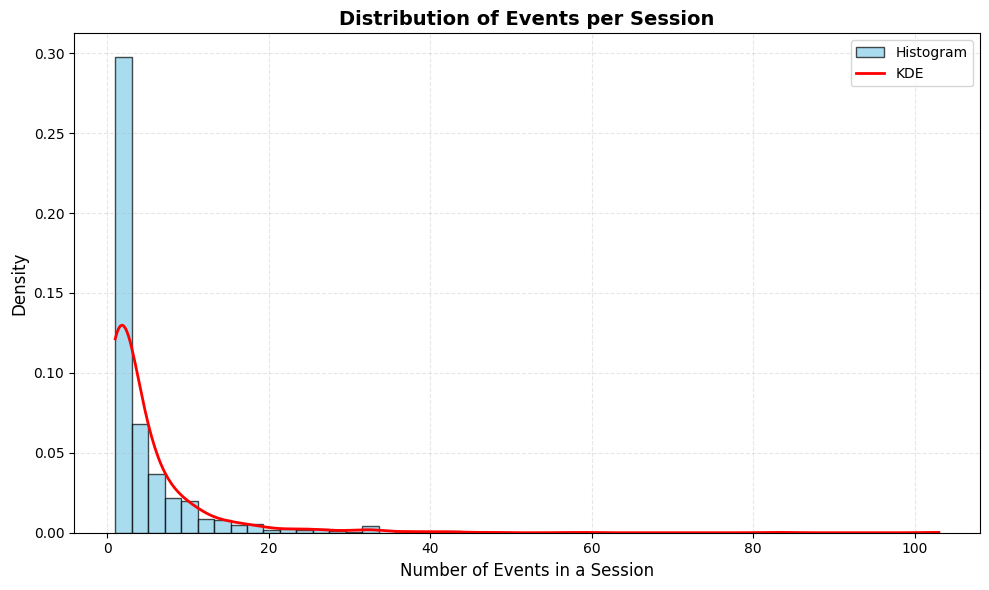

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getEventPerSessionDistrub(sample_size=1000) 
del rawDataAnalysis 

---


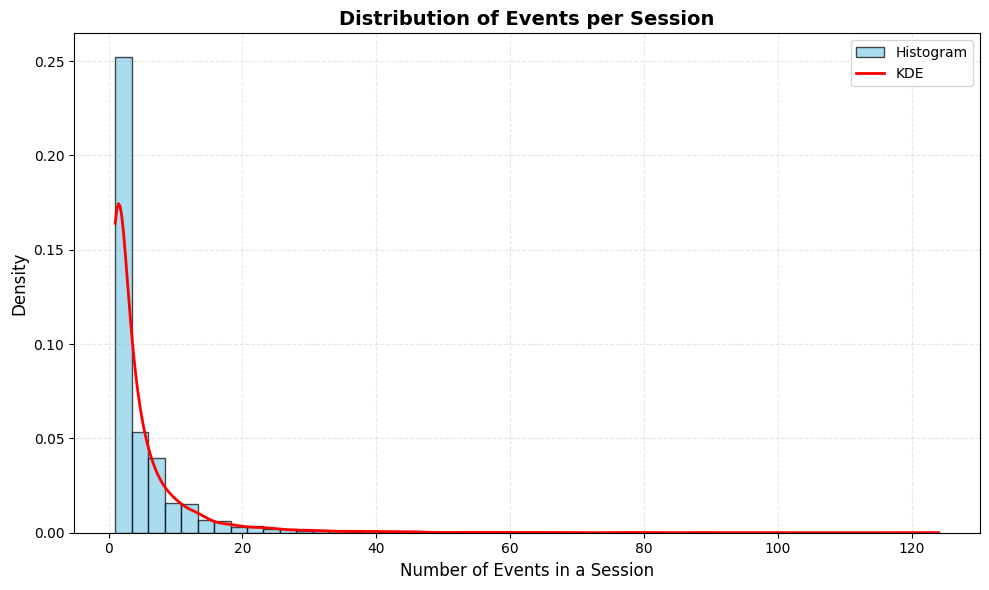

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getEventPerSessionDistrub(sample_size=10000) 
del rawDataAnalysis 

---


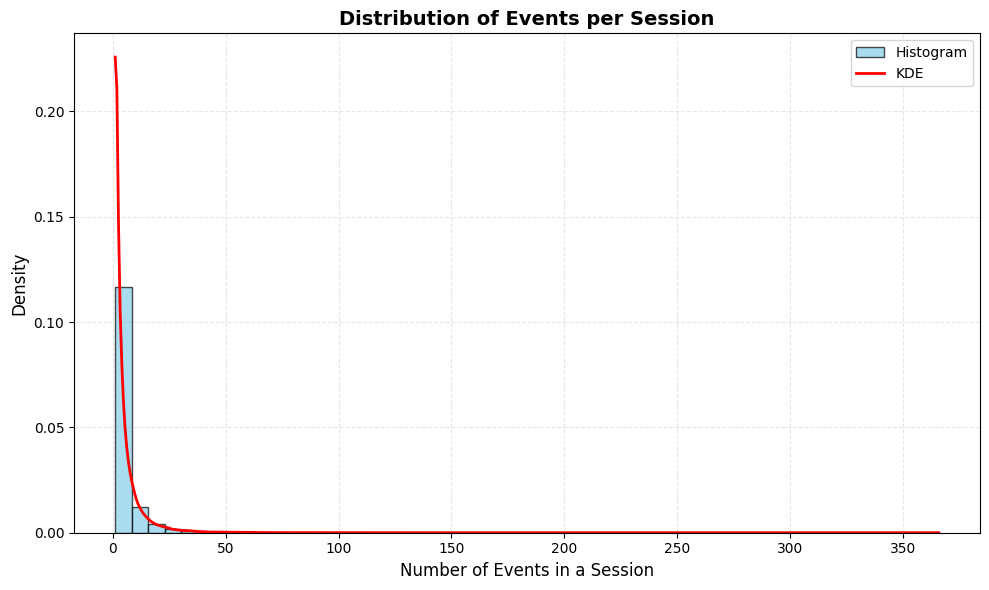

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getEventPerSessionDistrub(sample_size=100000) 
del rawDataAnalysis 

---


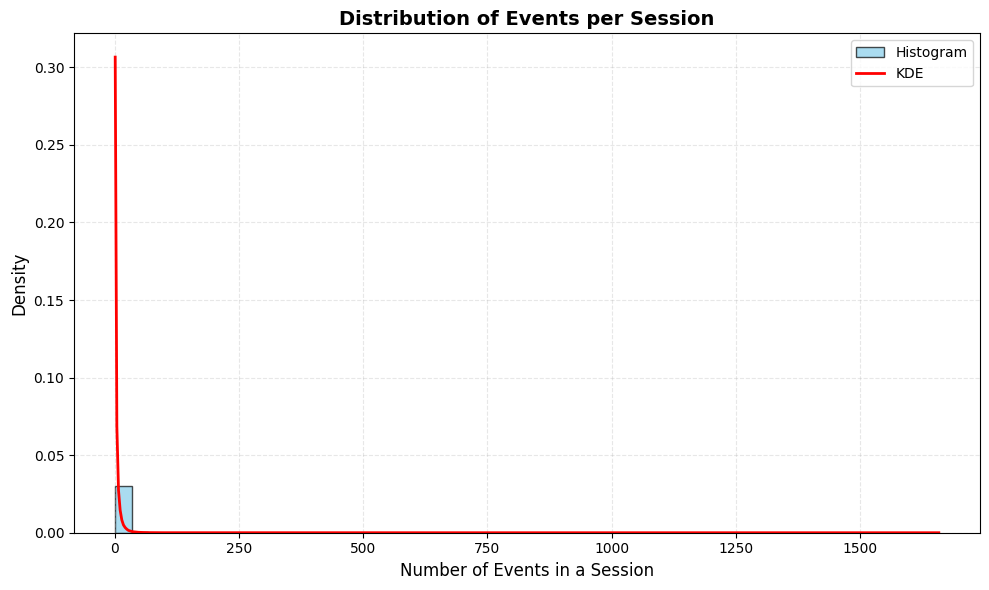

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getEventPerSessionDistrub(sample_size=1000000) 
del rawDataAnalysis 

---


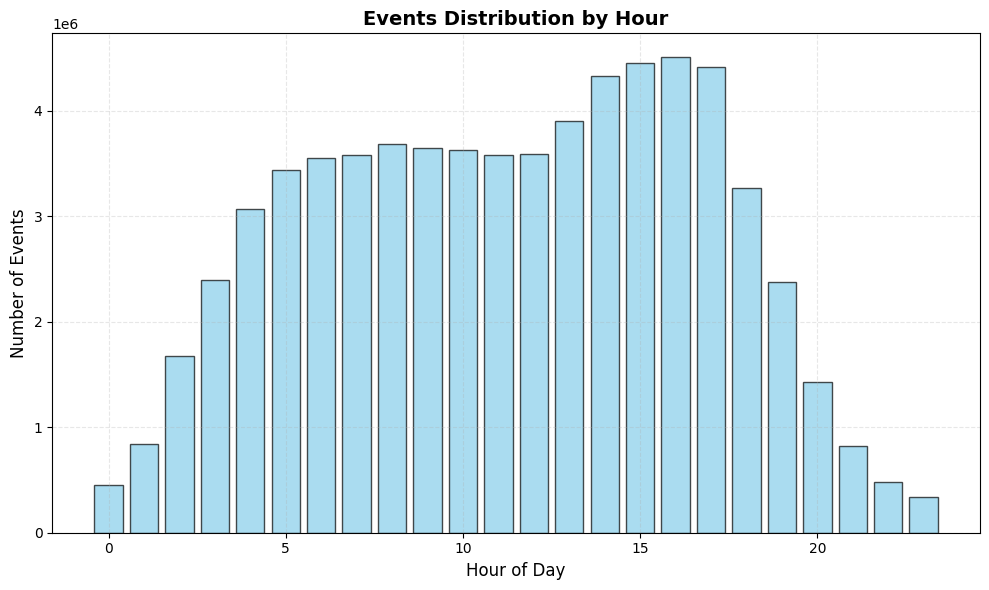

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.gettransactionVolume(by='hour')
del rawDataAnalysis 

---


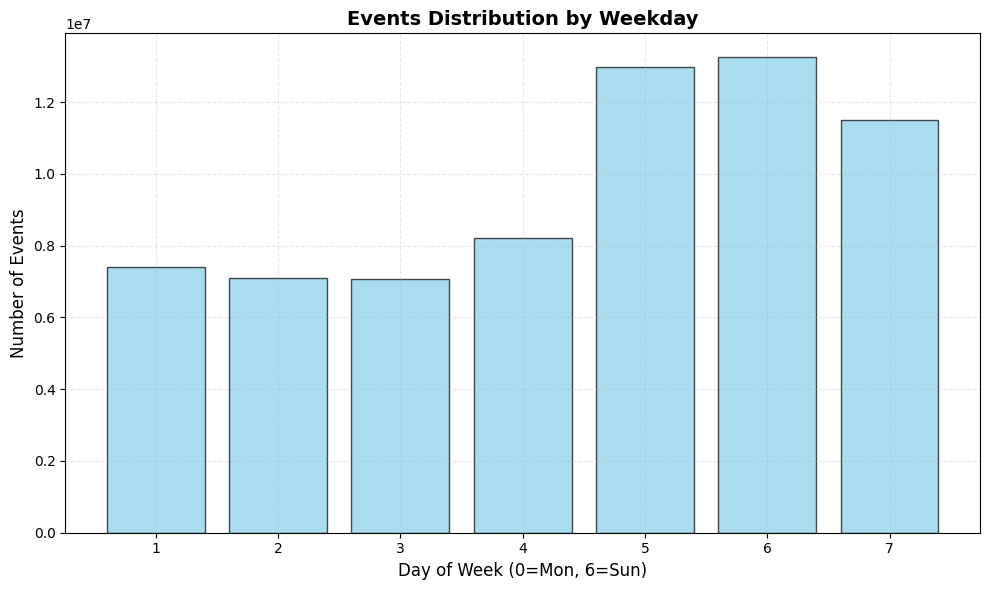

In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.gettransactionVolume(by='weekday')
del rawDataAnalysis

---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getSingleEventUserPct()
del rawDataAnalysis

The percentage of users of singular event sessisons is 26.53717401261919%



---

**Task 1.1.3: Data Volume and Distribution Analysis – November 2019 Dataset**

---
**Q1: What is the distribution of events per user session?**

* The distribution is **right-skewed**, with most sessions having very few events.
* Peak density is around **0.25–0.30** for low event counts.
* As the number of events per session increases, the density **drops sharply**.
* Only a small proportion of sessions have high event counts.

---

**Q2: How does the transaction volume vary by hour of day and day of week?**

**By Hour of Day:**

* Lowest activity occurs during **early morning (00–05)**.
* Activity rises steadily from **05–06** onwards.
* Peaks in the **afternoon (14–17)**.
* Declines gradually into the evening.

**By Day of Week:**

* Activity levels vary across weekdays.
* **Weekends (Friday–Sunday)** show the highest activity.
* Weekdays have more moderate activity levels.

---

**Q3: What percentage of users have only single-event sessions?**

* Approximately **26.5% of users** have sessions with only **one event**.
* This highlights that more than a quarter of users interact only once per session, while most users generate multi-event sessions.

---



## Task 1.2: Data Cleaning Implementation
---


### **Questions to Solve**:
---

### 1. **Outlier Detection and Treatment**
   - What constitutes a reasonable price range for each product category?
   - Which sessions have abnormally high event counts that might indicate bot activity?
   - How should we handle products with prices more than 3 standard deviations from the category mean?

---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getPriceRangeMainCategory()
del rawDataAnalysis

computers: raw range = 0.0$-2574.04$ | adjusted range = -654.465$-1545.815$ | avg = 534.56$ | median = 397.93$ (count=4181358)
electronics: raw range = 0.0$-2574.07$ | adjusted range = -475.43500000000006$-1203.4850000000001$ | avg = 424.14$ | median = 262.50$ (count=24006086)
sport: raw range = 0.0$-2573.81$ | adjusted range = -302.17499999999995$-846.0249999999999$ | avg = 369.57$ | median = 218.54$ (count=247994)
furniture: raw range = 0.0$-2574.04$ | adjusted range = -308.89$-803.11$ | avg = 287.95$ | median = 195.60$ (count=2111829)
country_yard: raw range = 0.0$-2426.32$ | adjusted range = -174.02999999999997$-627.01$ | avg = 275.74$ | median = 255.48$ (count=17719)
appliances: raw range = 0.0$-2574.04$ | adjusted range = -298.53999999999996$-681.54$ | avg = 234.01$ | median = 166.23$ (count=8489825)
construction: raw range = 0.0$-2570.79$ | adjusted range = -151.72500000000002$-398.875$ | avg = 172.97$ | median = 101.91$ (count=1092155)
auto: raw range = 0.0$-2165.76$ | adjusted

---

- Price Outlier Treatment Strategy:
            For zero-dollar products, preserve them as legitimate free items but validate by checking if they correlate with actual "purchase" events versus just "view" events. Use a flag-based system rather than removal - create is_free_item, is_luxury_item (>99.7th percentile), and is_extreme_outlier (>99.9th percentile) flags. This preserves all data while giving analytical flexibility. Set the price floor at $0.00 to keep free items, but track the minimum paid item price separately for monetary transaction analysis.
            The key principle is: flag, don't filter. This allows Marcus to analyze mainstream customers separately from luxury customers without losing potentially valuable business data about premium market segments.
---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
rawDataAnalysis.getNumberOfIrregularSessions()
del rawDataAnalysis

The percentage of suspicious sessions is 0.99%


---

- Strategy for Handling Abnormally High-Event Sessions
      To safeguard the integrity of customer behavior analysis while protecting the value of potential high-spending users, sessions with abnormally high event counts (≈1% of total) will not be immediately removed. Instead, they will be flagged as anomalies. In the cleaning phase, we will separate these sessions into two categories:
      Revenue-contributing sessions (with purchases): retained as possible power users or golden customers.
      Non-purchasing sessions: treated as likely automated traffic (bots) and excluded from customer-centric metrics.
      This two-step approach ensures that downstream analyses (such as churn modeling, funnel conversion, and golden customer identification) reflect true customer behavior, free from artificial inflation, while avoiding the risk of mistakenly discarding valuable heavy users.
---


In [ ]:
rawDataAnalysis = DataRawAnalysis("../Data/Raw/2019_nov_prqt/*.parquet")
df = rawDataAnalysis.getIrregularProductsSummary()
print(df)
del rawDataAnalysis

/tmp/ipykernel_5537/2430901163.py:517: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_products"),
/tmp/ipykernel_5537/2430901163.py:519: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.sum("is_irregular") / pl.count() * 100).alias("irregular_pct")
/tmp/ipykernel_5537/2430901163.py:530: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("total_products"),
/tmp/ipykernel_5537/2430901163.py:532: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.sum("is_irregular") / pl.count() * 100).alias("irregular_pct")


---

- Conclusion & Strategy for Luxury Product Outliers
    - Luxury items, while representing <1% of customers, significantly impact revenue and ROI.
    - Removing them would be equivalent to excluding a valuable customer segment.
    - To balance data quality with business insight, we will retain luxury purchases but flag them as a separate category.
    - In analyses sensitive to outliers, we will rely on robust metrics (e.g., median instead of mean) or segment calculations by the luxury - flag.
    - This approach minimizes engineering cost while preserving valuable insights about premium customers.


---

### 2. **Temporal Data Processing**
---

   - How can we standardize timestamp formats across different data sources?
      - We already Analyzed that the timestamp and came to a result that it is standard utc across all the records
   - What time zone should be used for normalizing international transactions?
      - All transaction timestamps will be standardized to UTC to ensure global consistency across analyses.
         The original local time zone information will be preserved in a separate column to allow region-specific reporting (e.g., campaigns by local time).
         This approach prevents confusion from daylight saving changes and avoids analytical bias when comparing customer behavior across different markets.
         Conclusion: UTC serves as the universal backbone for analytics, while local times act as optional overlays when needed by business teams.
   - How do we handle sessions that span multiple days?
     - Sessions spanning more than 24 hours (~0.15% of all sessions) are flagged as multi-day anomalies.
      Flagged sessions are further classified:
      With purchases: retained as potential golden/power users.
      Without purchases: treated as likely automated or bot activity and excluded from customer behavior metrics.
      This approach ensures that high-value customer behavior is preserved while preventing extreme sessions from distorting average session duration and funnel metrics.


---


### 3. **Categorical Data Standardization**
---

   - What is the optimal approach to handle hierarchical category codes with missing parent categories?
      - Top-level categories (a) are complete and reliable, so all analysis at this level is fully accurate.
         Subcategories (b and c) sometimes have missing values. Missing lower-level categories are flagged to indicate incomplete hierarchy.
         Primary analysis will rely on top-level categories to ensure metrics such as revenue, sessions, and engagement remain valid.
         Optional imputation of missing subcategories may be performed later if deep-granularity analysis is required, but only with clear documentation to avoid misleading insights.
         This approach balances accuracy, traceability, and business relevance, preserving actionable insights for cross-sell, segmentation, and golden customer identification.

   - How should we consolidate similar brand names with different spellings?
      - All similar brand name variants (e.g., "Sony", "SONY", "sony", "S0ny") will be unified under a single canonical name to eliminate noise.
         A mapping table of original → canonical names will be maintained for traceability and auditing purposes.
         This ensures accurate brand-level reporting, reliable identification of high-value customers, and effective cross-sell and recommendation strategies.
         By consolidating brands, we preserve the integrity of revenue and engagement metrics while simplifying downstream analytics.
   - What strategy should be used for grouping low-frequency product categories?
     -  Product categories with very few purchases or low transaction volume will be grouped into a single “Other” category to reduce noise in  analysis.
      A threshold (e.g., contributing less than 0.5% of total transactions or revenue) will be used to identify low-frequency categories.
      A mapping table will be maintained to allow drill-down if detailed insights are ever required.
      This approach simplifies reporting, enhances clarity in cross-sell and recommendation models, and ensures business focus remains on high-impact categories driving revenue and golden customer behavior


---

### **Task 1.2 – Data Cleaning & Distribution Strategies (Deep Dive)**

---

### 1. What constitutes a reasonable price range for each product category?

Defining a reasonable price range is essential for separating genuine customer behavior from noise, such as data errors or bot-driven anomalies. In e-commerce, price distributions are often heavily skewed, with the majority of products clustering in the low-to-mid range, while luxury items form a thin but important tail. Rather than applying blunt filtering, we adopt a **flag-based system** to preserve data richness while allowing Marcus to segment analysis flexibly.

**Price Outlier Treatment Strategy:**

* **Zero-dollar products:** Retain as legitimate free items, but validate by checking whether they are tied to **purchase events** (true free items) versus **view events** (potential data error).
* **Flag-based system:**

  * `is_free_item` → items priced at \$0.00
  * `is_luxury_item` → prices above the 99.7th percentile (≈3σ rule)
  * `is_extreme_outlier` → prices above the 99.9th percentile
* **Price floor:** Set at \$0.00 to keep free items. For monetary analysis, track the **minimum paid item price** separately.
* **Principle:** *Flag, don’t filter.*

  * This preserves customer segments that, while small, are strategically significant (luxury buyers). Removing them would erase insights into premium market contributions to ROI.

Formula for detecting luxury items:

$$
\text{isLuxuryItem} = 
\begin{cases} 
1 & \text{if Price} > P_{99.7} \\
0 & \text{otherwise}
\end{cases}
$$

---

### 2. Which sessions have abnormally high event counts that might indicate bot activity?

Some sessions generate unusually large numbers of events, far exceeding typical customer browsing patterns. These can either indicate **power users** (golden customers) or **bots scraping the website**. Instead of removing them outright, we preserve flexibility by flagging.

**Strategy:**

* Flag sessions with event counts above the **99th percentile** as anomalies.
* **With purchases:** Retain as **potential golden customers** worth special attention.
* **Without purchases:** Likely bots → exclude from customer behavior metrics.
* Use **robust statistics** (median, IQR, trimmed means) instead of averages when analyzing engagement to prevent distortion.

Formula for detection:

$$
\text{isSuspiciousSession} = 
\begin{cases} 
1 & \text{if EventCount} > P_{99} \\
0 & \text{otherwise}
\end{cases}
$$

---

### 3. How should we handle products with prices more than 3 standard deviations from the category mean?

Products priced at >3σ above the mean are often luxury items. Instead of discarding them, we treat them as **distinct signals of premium customer behavior**.

**Strategy:**

* Flag, don’t remove → preserve for analysis of high-value segments.
* Use robust metrics: **median** and **trimmed mean** for central tendency, reducing outlier distortion.
* Introduce a **luxury flag** into models, allowing Marcus to analyze both mainstream and premium segments without training separate models.

Formula for detection:

$$
\text{is3SigmaOutlier} = 
\begin{cases} 
1 & \text{if Price} > \mu + 3\sigma \\
0 & \text{otherwise}
\end{cases}
$$

---

### 4. How can we standardize timestamp formats across different data sources?

Timestamp consistency is crucial for sequencing events, calculating session durations, and identifying time-based behavior.

**Strategy:**

* Standardize all timestamps to **UTC** as the canonical format.
* Preserve original local timestamps in an auxiliary column for regional reporting.
* This ensures pipeline simplicity and avoids errors when merging data from multiple geographies.

$$
\text{event\_time\_standardized} = \text{convertToUTC(event\_time)}
$$

---

### 5. What time zone should be used for normalizing international transactions?

Consistency is essential for transaction data. Multiple time zones complicate global metrics and may obscure customer journeys.

**Strategy:**

* Normalize **all transactions to UTC**.
* Maintain local time metadata for regional drill-down.
* UTC ensures consistency for global KPIs, while local time provides business flexibility (e.g., local marketing campaigns).

---

### 6. How do we handle sessions that span multiple days?

A normal session should not extend across multiple calendar days. Long sessions may indicate bots or unusual edge cases.

**Strategy:**

* Flag sessions >24 hours as **multi-day anomalies**.
* Sub-classify:

  * **With purchases:** potential **power/golden users**
  * **Without purchases:** likely **bot-driven activity** → exclude from engagement analysis
* This balances the preservation of valuable revenue signals with the need for clean behavioral insights.

---

### 7. What is the optimal approach to handle hierarchical category codes with missing parent categories?

The dataset encodes categories as hierarchical paths (`a.b.c`). While **top-level categories** are complete, subcategories (`b`, `c`) may be missing.

**Strategy:**

* Rely on **top-level categories** (a) for all primary reporting since they are reliable.
* Flag missing mid-/low-level categories for traceability.
* If deep-dive analysis is needed, consider **controlled imputation** (e.g., fill missing `c` with `"unknown"`), but always document.

This ensures accurate reporting without overcomplicating the analysis.

---

### 8. How should we consolidate similar brand names with different spellings?

Brand name inconsistency (e.g., `"Sony"`, `"SONY"`, `"Sony Corp."`) creates noise in reporting and modeling.

**Strategy:**

* Normalize all variants under a **canonical brand name**.
* Maintain a **mapping table** (e.g., `SONY`, `Sony Corp.` → `Sony`).
* Guarantees accurate brand-level analytics, golden customer identification, and better recommendations.

---

### 9. What strategy should be used for grouping low-frequency product categories?

Rare categories add noise to analysis and modeling, while contributing little to insights.

**Strategy:**

* Group categories with frequency <0.5% of total transactions or revenue into an **“Other”** bucket.
* Maintain a mapping table for optional drill-down.
* Simplifies reporting, reduces model complexity, and focuses analysis on high-impact categories.

---

**Summary Principle:**
Across all data cleaning steps, we **preserve signal and avoid data loss**. Instead of discarding anomalies, we **flag strategically** (luxury items, bots, multi-day sessions). This ensures Marcus retains flexibility in exploring mainstream vs. niche segments, while giving analysts a clean foundation for robust, bias-resistant insights.

---



In [4]:
class DataCleaningPipeline:
    """
    A pipeline for cleaning, optimizing, and enriching raw e-commerce event data
    stored in Parquet format using the Polars library.

    The class is designed to:
      - Optimize data types to reduce memory usage and file size.
      - Flag anomalous, impossible, or rare user behaviors/sessions.
      - Enhance categorical features like `category_code` and `brand`.
      - Provide null analysis and frequency-based category tagging.

    Attributes
    ----------
    datapath : str
        Path to the input Parquet file containing raw event data.
    savePath : str
        Path where the cleaned/processed Parquet file will be saved.
    lazyDf : pl.LazyFrame
        A Polars LazyFrame object representing the dataset.
    """
    def __init__(self, datapath: str, savePath: str) -> None:
        """
        Initialize the DataCleaningPipeline with input and output file paths.

        Parameters
        ----------
        datapath : str
            Path to the input Parquet file.
        savePath : str
            Path where the cleaned dataset should be saved.

        Raises
        ------
        Exception
            If the Parquet file cannot be loaded.
        """
        self.datapath = datapath
        self.savePath = savePath
    
        try:
            self.lazyDf = pl.scan_parquet(datapath)
    
        except Exception as e:
            print(f"Error initializing the raw data analysis: {e}")
            raise
    
    def optimizeDataTypes(self) -> Self:
        """
        Optimize column data types to reduce storage and memory usage.

        - Cast `event_time` to a timezone-aware UTC datetime.
        - Downcast integer columns to Int8/Int16/Int32 where possible.
        - Downcast float columns to Float32/Float16 based on range.
        - Convert object/string columns to categorical type.
        - Save the optimized dataset to the `savePath`.

        Returns
        -------
        Self
            Returns the pipeline instance for method chaining.
        """
        self.lazyDf = pl.scan_parquet(self.datapath)
        int64Cols, objectCols, floatCols = [], [], []
        schema = self.lazyDf.collect_schema()
        columns = schema.names()

        self.lazyDf = self.lazyDf.with_columns(
            pl.col("event_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S %Z")
            .dt.replace_time_zone("UTC")
            .alias("event_time"))

        for column in columns:
            if schema[column] == pl.Int64:
                int64Cols.append(column)
            elif schema[column] == pl.Object:
                objectCols.append(column)
            elif schema[column] == pl.Float64:
                floatCols.append(column)

        int64MaxVals = (
            self.lazyDf
            .select([pl.col(c).max().alias(f"{c}_max") for c in int64Cols])
            .collect()
        )

        castExprs = []
        for column in int64Cols:
            maxVal = int64MaxVals[f"{column}_max"][0]
            if maxVal <= 127:
                castExprs.append(pl.col(column).cast(pl.Int8))
            elif maxVal <= 32767:
                castExprs.append(pl.col(column).cast(pl.Int16))
            elif maxVal <= 2147483647:
                castExprs.append(pl.col(column).cast(pl.Int32))

        if floatCols:
            floatStats = (
                self.lazyDf
                .select([pl.col(c).max().alias(f"{c}_max") for c in floatCols] +
                        [pl.col(c).min().alias(f"{c}_min") for c in floatCols])
                .collect()
            )
            for column in floatCols:
                minVal = floatStats[f"{column}_min"][0]
                maxVal = floatStats[f"{column}_max"][0]
                if minVal >= -3.4e38 and maxVal <= 3.4e38:
                    castExprs.append(pl.col(column).cast(pl.Float32))
                elif minVal >= -65504 and maxVal <= 65504:
                    castExprs.append(pl.col(column).cast(pl.Float16))

        for column in objectCols:
            castExprs.append(pl.col(column).cast(pl.Categorical))

        if castExprs:
            self.lazyDf = self.lazyDf.with_columns(castExprs)

        # Save optimized parquet
        self.lazyDf.collect().write_parquet(self.savePath)
        print(f"file {self.savePath} created successfully")
        return self

    def saveParquetFile(self) -> None:
        """
        Persist the current LazyFrame to disk in Parquet format.

        Notes
        -----
        - Writes the dataset to `self.savePath`.
        - Prints the dataset schema after saving.
        """
        df = self.lazyDf.collect()
        df.write_parquet(self.savePath)
        print(df.collect_schema())

    def flagProductsPerPrice(self) -> None:
        """
        Add flags for products based on their price distribution:

        - `isFreeItem` : True if price == 0.
        - `isLuxuryItem` : True if price is above the 99.7th percentile.
        - `isExtremeOutlier` : True if price is above the 99.9th percentile.

        The results are saved to the Parquet file.
        """
        self.lazyDf = self.lazyDf.with_columns([
            pl.when(pl.col('price') == 0).then(True).otherwise(False).alias("isFreeItem"),
            pl.when(pl.col('price') > pl.col('price').quantile(0.997)).then(True).otherwise(False).alias("isLuxuryItem"),
            pl.when(pl.col('price') > pl.col('price').quantile(0.999)).then(True).otherwise(False).alias("isExtremeOutlier"),
        ])

        self.saveParquetFile()
    
    def flagAbnormalSessions(self) -> None:
        """
        Flag sessions with an unusually high number of events.

        - Computes event counts per user session.
        - Uses IQR rule (Q3 + 3*IQR) to detect abnormal sessions.
        - Adds:
            - `isAbnormal` : True if the session is abnormal.
            - `has_purchase` : True if session contains at least one purchase.
        - Joins these flags back to the main dataset and saves the result.
        """
        eventCountPerUserSession = self.lazyDf.group_by('user_session').agg([pl.len().alias('event_count'), 
        pl.when(pl.col("event_type") == "purchase").then(True).otherwise(False).max().alias("has_purchase")])

        q1 = eventCountPerUserSession.select(pl.col("event_count").quantile(0.25)).collect().item()
        q3 = eventCountPerUserSession.select(pl.col("event_count").quantile(0.75)).collect().item()
        iqr = q3 - q1
        threshold = q3 + 3 * iqr
        eventCountPerUserSession = eventCountPerUserSession.with_columns([pl.when(pl.col('event_count') > threshold).
                                                                    then(True).otherwise(False).alias("isAbnormal")])
        self.lazyDf = self.lazyDf.join(eventCountPerUserSession.select([pl.col("user_session"),pl.col("isAbnormal"),pl.col("has_purchase")]),on="user_session")
        self.saveParquetFile()
    
    def flagImpossibleSessions(self) -> None:
        """
        Flag sessions with an unusually high number of events.

        - Computes event counts per user session.
        - Uses IQR rule (Q3 + 3*IQR) to detect abnormal sessions.
        - Adds:
            - `isAbnormal` : True if the session is abnormal.
            - `has_purchase` : True if session contains at least one purchase.
        - Joins these flags back to the main dataset and saves the result.
        """
        sessionDurations = (
            self.lazyDf.group_by("user_session")
            .agg(
                (
                    (pl.col("event_time").max() - pl.col("event_time").min())
                    .dt.total_seconds().cast(pl.Float64) / 3600
                ).alias("durationHours")
            )
            .with_columns(
                (pl.col("durationHours") > 24).alias("isMultiDaySession")
            )
        )

        # Join flag back to the main dataset
        self.lazyDf = self.lazyDf.join(
            sessionDurations.select(["user_session", "isMultiDaySession"]),
            on="user_session",
        )

        # Save
        self.saveParquetFile()

    def nullAnalysis(self) -> dict:
        """
        Perform null-value analysis for all columns.

        Returns
        -------
        dict
            Dictionary containing per-column null counts under key `"nullCounts"`.

        Notes
        -----
        Also prints null counts to the console.
        """
        allCols = self.lazyDf.collect_schema().names()
        nullCountsLazy = self.lazyDf.select([pl.col(c).is_null().sum().alias(c) for c in allCols])
        nullCountsRes = nullCountsLazy.collect()
        nullCounts = {c: nullCountsRes[0, c] for c in allCols}
        print("\nNull counts per column:")
        for col, count in nullCounts.items():
            print(f"{col}: null count ({count})")

        return {"nullCounts": nullCounts}

    def optimizeCategoryCode(self) -> None:
        """
        Transform the `category_code` column into hierarchical levels.

        - Adds:
            - `hasCategoryCode` : True if category_code is not null.
            - `category_l1` : First category level (before first dot).
            - `category_l2` : Two-level category (before second dot).
            - `category_l3` : Third-level category if available.
        - Missing values are filled with `"unknown"`.
        - Drops the original `category_code` column.
        - Saves the updated dataset.
        """
        self.lazyDf = self.lazyDf.with_columns([
            pl.col("category_code").is_not_null().alias("hasCategoryCode"),

            # Extract level 1 (before first dot)
            pl.col("category_code")
            .str.extract(r"^([^.]+)", 1)
            .fill_null("unknown")
            .alias("category_l1"),

            # Extract level 2 (first two parts)
            pl.col("category_code")
            .str.extract(r"^([^.]+\.[^.]+)", 1)
            .fill_null("unknown")
            .alias("category_l2"),

            # Extract level 3 (third part if exists)
            pl.col("category_code")
            .str.extract(r"^[^.]+\.[^.]+\.([^.]+)", 1)
            .fill_null("unknown")
            .alias("category_l3"),
        ])

        # Drop original column
        self.lazyDf = self.lazyDf.drop("category_code")

        self.saveParquetFile()

    def optimizeBrand(self) -> None:
        """
        Standardize the `brand` column.

        - Removes placeholder column `__null_dask_index__` if present.
        - Converts brand names to lowercase.
        - Strips punctuation and special characters (" .,-_").
        - Replaces null values with `"unknown"`.
        - Saves the result.
        """
        self.lazyDf = self.lazyDf.drop("__null_dask_index__")
        self.lazyDf = self.lazyDf.with_columns(pl.col('brand').str.to_lowercase().str.strip_chars(" .,-_").fill_null("unknown").alias('brand'))
        self.saveParquetFile()

    def flagLowFrequencyCategories(self) -> None:
        """
        Flag low-frequency product categories based on transaction share.

        - Calculates each category's percentage of total price sum.
        - Marks categories as low-frequency if their share <= 0.5%.
        - Adds:
            - `isLowFrequencyCategory` : True if category share <= 0.5%.
        - Prints the number of low-frequency categories detected.
        - Joins this flag back to the dataset and saves.
        """
        TotalTrans = self.lazyDf.select(pl.col('price').sum()).collect().item()
        pricePerCat = self.lazyDf.group_by('category_l1').agg([((pl.col('price').sum()/TotalTrans)*100).alias("categoryTransPercentage")])
        pricePerCat = pricePerCat.with_columns([pl.when(pl.col("categoryTransPercentage") <= 0.5).then(True).otherwise(False).alias("isLowFrequencyCategory")])
        lowCatCount = pricePerCat.filter(pl.col("isLowFrequencyCategory")).collect().height
        print(f"The Number of Low Frequency Categories with less than or equal to 0.5% is {lowCatCount}")
        self.lazyDf = self.lazyDf.join(
            pricePerCat.select(["category_l1", "isLowFrequencyCategory"]),
            on="category_l1",
        )
        self.saveParquetFile()

In [19]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Raw/2019_nov_prqt/*.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.optimizeDataTypes()
del cleaningPipeline

file ../Data/Processed/prsc_nov_2019.parquet created successfully


In [20]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.flagProductsPerPrice()
del cleaningPipeline


Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('category_code', String), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('__null_dask_index__', Int32), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean)])


In [21]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.flagAbnormalSessions()
del cleaningPipeline


Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('category_code', String), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('__null_dask_index__', Int32), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean)])


In [22]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.flagImpossibleSessions()
del cleaningPipeline


Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('category_code', String), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('__null_dask_index__', Int32), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean)])


In [23]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.optimizeCategoryCode()
del cleaningPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('__null_dask_index__', Int32), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String)])


In [24]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.optimizeBrand()
del cleaningPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String)])


In [6]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.nullAnalysis()
del cleaningPipeline


Null counts per column:
event_time: null count (0)
event_type: null count (0)
product_id: null count (0)
category_id: null count (0)
brand: null count (0)
price: null count (0)
user_id: null count (0)
user_session: null count (0)
isFreeItem: null count (0)
isLuxuryItem: null count (0)
isExtremeOutlier: null count (0)
isAbnormal: null count (0)
has_purchase: null count (0)
isMultiDaySession: null count (0)
hasCategoryCode: null count (0)
category_l1: null count (0)
category_l2: null count (0)
category_l3: null count (0)


In [3]:
cleaningPipeline = DataCleaningPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_nov_2019.parquet")
cleaningPipeline.flagLowFrequencyCategories()
del cleaningPipeline

The Number of Low Frequency Categories with less than or equal to 0.5% is 5
Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean)])



---

### **Task 1.3 – Feature Engineering (Deep Dive)**

---

### 1. How can we calculate accurate session duration when some events lack proper sequencing?

Session duration is typically measured as the time between the first and last recorded event in a session. However, in practice, event logs may be incomplete, out of order, or missing timestamps due to technical tracking issues. In our dataset, while sequencing is mostly intact, there will inevitably be noise—sessions that appear to end abruptly, sessions with only one event, or sessions where the duration comes out as zero. Instead of discarding these, the most robust approach is to calculate duration as:

$$
\text{SessionDuration} = \max(\text{event\_time}) - \min(\text{event\_time})
$$

for each session, while adding flags for anomalies such as durations less than a minute or excessively long durations that might indicate bot-like activity. This way, Marcus retains the flexibility to decide whether to exclude or separately analyze these edge cases, while we preserve data completeness for mainstream customers.

---

### 2. What time-based features best capture seasonal shopping patterns?

Although our dataset is limited to **November 2019**, time-based features are still critical for uncovering weekly shopping cycles and short-term seasonality. For instance, by encoding **day-of-week** and **week-of-month**, we can identify whether customers are more active on Fridays leading up to payday or if there is an observable spike during Black Friday promotions. Even within a single month, these micro-seasonal effects can be very pronounced in e-commerce. Additional features such as **hour-of-day** can help highlight peak shopping windows—lunchtime browsing vs. late-night impulse buying. While the dataset does not allow us to analyze full yearly patterns, these short-term cycles are still highly actionable for campaign optimization and resource planning.

---

### 3. How do we identify and flag weekend vs. weekday behavioral differences?

Consumer behavior often shifts between weekdays and weekends: weekdays may see more browsing during work breaks, while weekends typically attract more deliberate shopping with higher conversion intent. To capture this, we create a simple **binary weekend flag**:

$$
\text{isWeekend} = 
\begin{cases} 
1 & \text{if day\_of\_week} \in \{Saturday, Sunday\} \\
0 & \text{otherwise}
\end{cases}
$$

Once separated, we can analyze differences in session duration, product views, cart abandonment, and conversion rates between the two groups. This segmentation is especially useful when planning targeted marketing campaigns—for example, offering quick-browse promotions during the week versus deeper discounts or bundles on weekends. Treating weekdays and weekends as distinct behavioral segments ensures that strategies align with the natural rhythm of customer shopping habits.

---

### 4. What constitutes a "page view" vs. "purchase" in the event sequence?

In this dataset, events are already tagged as *view, cart,* or *purchase*. The challenge is to decide whether standalone purchases without recorded views should be accepted as valid. Our stance is that all **purchase events are legitimate** even if no preceding view is captured. This accommodates scenarios like users coming directly from an email campaign or retargeting ad, where the view event might occur outside the tracked session. To avoid misclassification, we will flag standalone purchases as:

$$
\text{isDirectPurchase} = 
\begin{cases} 
1 & \text{if purchase exists but no view in session} \\
0 & \text{otherwise}
\end{cases}
$$

This allows Marcus to analyze the subset separately if needed, while ensuring no true revenue signals are lost due to imperfect tracking.

---

### 5. How can we calculate cart abandonment rates at the user session level?

Cart abandonment is one of the most critical e-commerce KPIs because it reflects lost revenue opportunities. We define cart abandonment at the **session level**: if a session includes a cart event but does not culminate in a purchase, it is counted as abandoned. The formula is:

$$
\text{CartAbandonmentRate} = \frac{\text{Sessions with Cart but no Purchase}}{\text{Sessions with Cart}}
$$

To add nuance, we calculate this not only at the aggregate level but also by **product category**, since abandonment can be influenced by category-specific dynamics like high shipping costs (electronics) or indecision (fashion). Tracking abandonment rates by category helps identify friction points in the conversion funnel and provides actionable insights into where UX improvements or promotional nudges would have the greatest impact.

---

### 6. What metric best captures customer engagement depth within a session?

Engagement depth should reflect how far a customer explores the catalog in a given session. Among several possible measures, **unique products viewed per session** stands out as the most robust. It captures both breadth (exposure to different products) and intent (the deeper someone browses, the more likely they are to be seriously shopping). The formula is:

$$
\text{EngagementDepth} = \text{count}(\text{distinct product\_id viewed in session})
$$

This can be supplemented with **funnel progression flags**—whether the session advanced from view → cart → purchase—to distinguish between shallow browsers and engaged buyers. Taken together, these metrics help Marcus differentiate between “window shoppers” and customers who exhibit stronger purchase intent.

---

### 7. How can we create a product popularity score that accounts for both views and purchases?

Pure view counts or purchase counts alone give an incomplete picture of popularity. A balanced metric should integrate both, with purchases weighted more heavily since they represent direct revenue. We propose a **weighted popularity score**:

$$
\text{PopularityScore}_{i} = 0.7 \cdot \frac{\text{Purchases}_{i}}{\max(\text{Purchases})} + 0.3 \cdot \frac{\text{Views}_{i}}{\max(\text{Views})}
$$

where $i$ is the product.
This ensures that products with high conversion rates rise to the top, while still recognizing that heavily viewed but less frequently purchased products may be aspirational items worth highlighting. The score provides Marcus with a nuanced ranking system that accounts for both demand and revenue potential, making it ideal for powering product recommendations and merchandising decisions.

---

### 8. What approach should be used to calculate category-specific conversion rates?

Conversion rates are a key lens into category performance. We define **category conversion rate** as:

$$
\text{ConversionRate}_{c} = \frac{\text{Purchases}_{c}}{\text{Views}_{c}}
$$

where $c$ is the category. By calculating this at the **main category level** (rather than diving too deeply into subcategories), we strike a balance between actionable insights and statistical reliability. For example, if Electronics shows a 12% conversion rate but Apparel shows only 4%, Marcus can prioritize investment in categories with stronger sales efficiency. This approach avoids the noise of fragmented subcategory-level calculations, while still offering enough granularity to drive meaningful business decisions.

---

### 9. How do we handle products that appear across multiple categories when calculating performance metrics?

Some products are cross-listed under multiple categories, which can create duplication and bias in performance metrics. To resolve this, each product should be assigned a **primary category** based on its most logical or frequently occurring placement. At the same time, we maintain a **multi-category flag**:

$$
\text{isMultiCategory} = 
\begin{cases} 
1 & \text{if product appears in > 1 category} \\
0 & \text{otherwise}
\end{cases}
$$

This dual system ensures clarity for high-level KPIs while preserving analytical flexibility. By assigning a primary category, we avoid double-counting in conversion rate or popularity metrics, while still allowing Marcus to explore multi-category overlaps when examining product placement strategies.

---

**Summary Principle:**
Across all feature engineering steps, we prioritize **clarity, robustness, and analytical flexibility**. Rather than filtering out anomalies, we preserve them through careful flagging and structured feature creation. This ensures Marcus has a clean, reliable dataset for mainstream insights while still retaining the richness needed to explore power users, outliers, and premium segments.

---



In [ ]:
class FeatureEngineeringPipeline:
    """
    A feature engineering pipeline for processing and enriching large-scale 
    e-commerce clickstream data using Polars' lazy evaluation.

    This pipeline builds on cleaned and pre-processed datasets (Task 1.2) 
    and focuses on generating higher-level behavioral, temporal, and 
    product/category features that are crucial for downstream exploratory 
    data analysis (EDA), modeling, and business insights.

    The pipeline is optimized for:
    - Efficient computation using Polars' lazy execution engine.
    - Memory reduction through intelligent type downcasting.
    - Flexibility in adding new engineered features without breaking 
      the workflow.
    - Saving results directly to Parquet files for scalability.

    Parameters
    ----------
    datapath : str
        Path to the input dataset in Parquet format.
    savePath : str
        Path where the enriched dataset should be written.

    Attributes
    ----------
    datapath : str
        Location of the source dataset.
    savePath : str
        Destination for saving engineered datasets.
    lazyDf : pl.LazyFrame
        The dataset loaded in Polars' lazy mode, enabling query optimization 
        before materialization.

    Methods
    -------
    optimizeDataTypes() -> Self
        Downcast integers/floats where possible, convert objects to categoricals, 
        and ensure datetime consistency. Saves optimized dataset.
    
    saveParquetFileLazy() -> None
        Persist the current state of the lazy dataframe to a Parquet file 
        at `savePath`.

    constructTemporalFeatures() -> None
        Adds temporal/session-level features:
        - Session duration in hours.
        - Session start hour and day-of-week.
        - Weekend session flag.
        - Midnight activity indicator.
        Results are joined back at the `user_session` level.

    constructPurchaseFeatures() -> None
        Derives purchase funnel signals:
        - Counts of views, purchases, and cart events per session.
        - Flags direct purchases (no views but at least one purchase).
        - Flags abandoned carts (items in cart but no purchases).

    constructEngagementFeatures() -> None
        Quantifies engagement per session:
        - Engagement depth = number of unique products interacted with.
        - Advanced-to-cart and advanced-to-purchase boolean indicators.

    constructPopularityScore(purchaseWeight: float = 0.7, viewWeight: float = 0.3) -> None
        Computes a product-level popularity score as a weighted combination 
        of normalized purchase and view counts. Allows custom weight tuning.

    constructCategoryConversionRate() -> None
        Calculates category-level conversion rates:
        - Conversion = purchaseCount / viewCount at the `category_l1` level.
        - Ensures robust handling of categories with zero views.

    flagMultiCategoriesProduct() -> None
        Flags products that belong to multiple distinct top-level categories, 
        which may indicate catalog inconsistencies or cross-category appeal.

    Notes
    -----
    - Each transformation step saves its output immediately to Parquet 
      (`savePath`) to ensure checkpointing and reproducibility.
    - Methods are modular, so they can be executed independently or chained.
    - Designed specifically for the E-commerce Customer Behavior Analysis project, 
      but extensible to other event-based clickstream datasets.

    Example
    -------
    >>> pipeline = FeatureEngineeringPipeline(
    ...     datapath="../Data/Processed/prsc_fe_nov_2019.parquet",
    ...     savePath="../Data/Processed/prsc_fe_nov_2019.parquet"
    ... )
    >>> pipeline.optimizeDataTypes()
    >>> pipeline.constructTemporalFeatures()
    >>> pipeline.constructPurchaseFeatures()
    >>> pipeline.constructEngagementFeatures()
    >>> pipeline.constructPopularityScore()
    >>> pipeline.constructCategoryConversionRate()
    >>> pipeline.flagMultiCategoriesProduct()
    """

    def __init__(self, datapath: str, savePath: str) -> None:
        """
        Initialize the FeatureEngineeringPipeline with input and output file paths.

        Parameters
        ----------
        datapath : str
            Path to the input Parquet file containing raw e-commerce event data.
        savePath : str
            Path where the engineered dataset should be saved.

        Raises
        ------
        Exception
            If the Parquet file cannot be loaded successfully.
        """
        self.datapath = datapath
        self.savePath = savePath
    
        try:
            self.lazyDf = pl.scan_parquet(datapath)
    
        except Exception as e:
            print(f"Error initializing the raw data analysis: {e}")
            raise
    
    def optimizeDataTypes(self) -> Self:
        """
        Optimize column data types to reduce memory usage and improve performance.

        Actions Performed
        -----------------
        - Cast `event_time` to a timezone-aware UTC datetime.
        - Downcast integer columns from Int64 → Int8/Int16/Int32 based on value ranges.
        - Downcast float columns from Float64 → Float32 when values fit within the safe range.
        - Convert object/string columns to categorical types for compression.
        - Saves the optimized dataset to the specified `savePath`.

        Returns
        -------
        Self
            Returns the pipeline instance for method chaining.
        """
        self.lazyDf = pl.scan_parquet(self.datapath)
        int64Cols, objectCols, floatCols = [], [], []
        schema = self.lazyDf.collect_schema()
        columns = schema.names()

        for column in columns:
            if schema[column] == pl.Int64:
                int64Cols.append(column)
            elif schema[column] == pl.Object:
                objectCols.append(column)
            elif schema[column] == pl.Float64:
                floatCols.append(column)

        int64MaxVals = (
            self.lazyDf
            .select([pl.col(c).max().alias(f"{c}_max") for c in int64Cols])
            .collect()
        )

        castExprs = []
        for column in int64Cols:
            maxVal = int64MaxVals[f"{column}_max"][0]
            if maxVal <= 127:
                castExprs.append(pl.col(column).cast(pl.Int8))
            elif maxVal <= 32767:
                castExprs.append(pl.col(column).cast(pl.Int16))
            elif maxVal <= 2147483647:
                castExprs.append(pl.col(column).cast(pl.Int32))

        if floatCols:
            floatStats = (
                self.lazyDf
                .select([pl.col(c).max().alias(f"{c}_max") for c in floatCols] +
                        [pl.col(c).min().alias(f"{c}_min") for c in floatCols])
                .collect()
            )
            for column in floatCols:
                minVal = floatStats[f"{column}_min"][0]
                maxVal = floatStats[f"{column}_max"][0]
                if minVal >= -3.4e38 and maxVal <= 3.4e38:
                    castExprs.append(pl.col(column).cast(pl.Float32))

        for column in objectCols:
            castExprs.append(pl.col(column).cast(pl.Categorical))

        if castExprs:
            self.lazyDf = self.lazyDf.with_columns(castExprs)

        # Save optimized parquet
        self.saveParquetFileLazy()
    
    def saveParquetFileLazy(self) -> None:
        """
        Save the current lazy Polars DataFrame to the defined `savePath`.

        Notes
        -----
        - Uses `sink_parquet` for efficient saving without forcing a full collection.
        - Prints the current schema after saving to confirm transformations.
        """
        self.lazyDf.sink_parquet(self.savePath)  
        print(self.lazyDf.collect_schema())
        
    def constructTemporalFeatures(self) -> None:
        """
        Construct temporal (time-based) session-level features.

        Features Created
        ----------------
        - `sessionDuration` : Duration of a session in hours, computed as:
            sessionDuration = (max(event_time) - min(event_time)) / 3600
        - `sessionStartHour` : Hour of the day when the session began.
        - `sessionDayOfWeek` : Day of the week (e.g., Monday, Tuesday).
        - `isMidnightActivity` : Flag if any activity occurred between 00:00–05:00.
        - `isWeekendSession` : Flag if session started on Saturday or Sunday.

        Output
        ------
        Joins these features back to the main dataset at `user_session` level,
        then saves to Parquet.
        """
        TemporalFeatures = (
            self.lazyDf.group_by("user_session")
            .agg([
                # Duration in hours
                ((pl.col("event_time").max() - pl.col("event_time").min())
                    .dt.total_seconds().cast(pl.Float64) / 3600).alias("sessionDuration"),

                # Session start features
                pl.col("event_time").min().dt.hour().alias("sessionStartHour"),
                pl.col("event_time").min().dt.strftime("%A").alias("sessionDayOfWeek"),

                # Midnight activity flag (session-level)
                (pl.col("event_time").dt.hour().is_between(0, 5)).any().alias("isMidnightActivity")
            ])
            .with_columns([
                pl.when(pl.col("sessionDayOfWeek").is_in(["Saturday", "Sunday"]))
                .then(True)
                .otherwise(False)
                .alias("isWeekendSession")
            ])
        )

        # Join back to main dataset
        self.lazyDf = self.lazyDf.join(
            TemporalFeatures.select(["user_session", "sessionDuration", "sessionStartHour",
                                    "sessionDayOfWeek", "isWeekendSession", "isMidnightActivity"]),
            on="user_session",
        )
        self.saveParquetFileLazy()
    
    def constructPurchaseFeatures(self) -> None:
        """
        Construct purchase-related behavioral features at the session level.

        Features Created
        ----------------
        - `viewCount` : Total number of "view" events in the session.
        - `purchaseCount` : Total number of "purchase" events in the session.
        - `cartCount` : Total number of "cart" events in the session.
        - `isDirectPurchase` : Flag if purchase occurred without any prior views.
        - `isAbandonedCart` : Flag if items were added to cart but no purchase occurred.

        Output
        ------
        Joins these features back to the main dataset at `user_session` level,
        then saves to Parquet.
        """
        eventsCount = (
            self.lazyDf
            .group_by("user_session")
            .agg([
                (pl.col("event_type") == "view").sum().alias("viewCount"),
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "cart").sum().alias("cartCount"),

            ])
        )
        eventsCount = eventsCount.with_columns([pl.when((pl.col("viewCount") == 0) & (pl.col("purchaseCount") >= 1)).
                                                then(True).otherwise(False).alias('isDirectPurchase'), 
                                                pl.when((pl.col("cartCount") > 0) & (pl.col("purchaseCount") == 0)).
                                                then(True).otherwise(False).alias('isAbandonedCart')])
        self.lazyDf = self.lazyDf.join(eventsCount.select(['user_session', 'isDirectPurchase', 'isAbandonedCart']), on='user_session')
        self.saveParquetFileLazy()
        
    def constructEngagementFeatures(self) -> None:
        """
        Construct engagement-related features reflecting user depth of interaction.

        Features Created
        ----------------
        - `EngagementDepth` : Number of unique products interacted with in the session.
        - `purchaseCount` : Total purchases (for internal logic).
        - `cartCount` : Total carts (for internal logic).
        - `advancedToPurchase` : Flag if session advanced to purchase stage.
        - `advancedToCart` : Flag if session advanced to cart stage.

        Output
        ------
        Joins these features back to the main dataset at `user_session` level,
        then saves to Parquet.
        """
        eventsCount = (
            self.lazyDf
            .group_by("user_session")
            .agg([
                (pl.col("product_id").n_unique()).alias("EngagementDepth"),
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "cart").sum().alias("cartCount"),
            ])
        )
        eventsCount = eventsCount.with_columns([pl.when(pl.col("purchaseCount") > 0).
                                                then(True).otherwise(False).alias('advancedToPurchase'), 
                                                pl.when(pl.col("cartCount") > 0).
                                                then(True).otherwise(False).alias('advancedToCart')])
        self.lazyDf = self.lazyDf.join(eventsCount.select(['user_session', 'advancedToCart', 'advancedToPurchase', 'EngagementDepth']), on='user_session')
        self.saveParquetFileLazy()

    def constructPopularityScore(self, purchaseWeight:float=0.7, viewWeight:float=0.3) -> None:
        """
        Construct product-level popularity score by weighting purchases and views.

        Parameters
        ----------
        purchaseWeight : float, default=0.7
            Relative importance of purchases in the score (range: 0–1).
        viewWeight : float, default=0.3
            Relative importance of views in the score (range: 0–1).

        Formula
        -------
        popularityScore = (purchaseWeight * (purchaseCount / maxPurchaseCount)) +
                          (viewWeight * (viewCount / maxViewCount))

        Features Created
        ----------------
        - `popularityScore` : Normalized score representing item popularity.

        Output
        ------
        Joins `popularityScore` back to the dataset at `product_id` level,
        then saves to Parquet.
        """
        eventCount = (
            self.lazyDf
            .group_by("product_id")
            .agg([
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "view").sum().alias("viewCount"),
            ])
        )

        maxPurchaseValue = eventCount.select(pl.max("purchaseCount")).collect().item()
        maxViewValue = eventCount.select(pl.max("viewCount")).collect().item()

        eventCount = eventCount.with_columns([
            (purchaseWeight * (pl.col("purchaseCount") / maxPurchaseValue)).alias("weightedPurchase"),
            (viewWeight * (pl.col("viewCount") / maxViewValue)).alias("weightedView"),
        ])
        eventCount = eventCount.with_columns([
            (pl.col("weightedPurchase") + pl.col("weightedView")).alias("popularityScore")
        ])

        self.lazyDf = self.lazyDf.join(
            eventCount.select(["product_id", "popularityScore"]),
            on="product_id"
        )

        self.saveParquetFileLazy()

    def constructCategoryConversionRate(self) -> None:
        """
        Construct category-level conversion rates.

        Formula
        -------
        categoryConversionRate = purchaseCount / viewCount, if viewCount > 0
                                 0 otherwise

        Features Created
        ----------------
        - `categoryConversionRate` : Likelihood of a view in a category resulting in a purchase.

        Output
        ------
        Joins this feature back to the dataset at `category_l1` level,
        then saves to Parquet.
        """
        eventCount = (
            self.lazyDf
            .group_by("category_l1")
            .agg([
                (pl.col("event_type") == "purchase").sum().alias("purchaseCount"),
                (pl.col("event_type") == "view").sum().alias("viewCount"),
            ])
        )
        eventCount = eventCount.with_columns([
            pl.when(pl.col("viewCount") > 0)
            .then(pl.col("purchaseCount") / pl.col("viewCount"))
            .otherwise(0)
            .alias("categoryConversionRate")
        ])

        self.lazyDf = self.lazyDf.join(
            eventCount.select(["category_l1", "categoryConversionRate"]),
            on="category_l1"
        )

        self.saveParquetFileLazy()
    
    def flagMultiCategoriesProduct(self) -> None:
        """
        Flag products that belong to multiple categories.

        Features Created
        ----------------
        - `uniqueCategories` : Number of distinct categories a product belongs to.
        - `isInMultiCategories` : Flag if product appears in more than one category.

        Output
        ------
        Joins these features back to the dataset at `product_id` level,
        then saves to Parquet.
        """
        categoryCountUnique = (
            self.lazyDf
            .group_by("product_id")
            .agg([
                (pl.col("category_l1").n_unique()).alias("uniqueCategories"),
            ])
        )
        categoryCountUnique = categoryCountUnique.with_columns([pl.when(pl.col('uniqueCategories') > 1).then(True).otherwise(False).alias('isInMultiCategories')])
        self.lazyDf = self.lazyDf.join(categoryCountUnique.select(['product_id', 'isInMultiCategories']), on='product_id')
        self.saveParquetFileLazy()

    

In [4]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_nov_2019.parquet",savePath="../Data/Processed/prsc_fe_nov_2019.parquet")
fetPipeline.constructTemporalFeatures()
del fetPipeline


Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float64), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean)])


In [16]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe2_nov_2019.parquet",savePath="../Data/Processed/prsc_fe3_nov_2019.parquet")
fetPipeline.constructPurchaseFeatures()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float64), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean)])


In [20]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe3_nov_2019.parquet",savePath="../Data/Processed/prsc_fe4_nov_2019.parquet")
fetPipeline.constructEngagementFeatures()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float64), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32)])


In [7]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe4_nov_2019.parquet",savePath="../Data/Processed/prsc_fe5_nov_2019.parquet")
fetPipeline.constructPopularityScore()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float64), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32), ('popularityScore', Float64)])


In [10]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe5_nov_2019.parquet",savePath="../Data/Processed/prsc_fe6_nov_2019.parquet")
fetPipeline.optimizeDataTypes()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float32), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32), ('popularityScore', Float32)])


In [12]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe6_nov_2019.parquet",savePath="../Data/Processed/prsc_fe7_nov_2019.parquet")
fetPipeline.constructCategoryConversionRate()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float32), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32), ('popularityScore', Float32), ('categoryConversionRate', Float64)])


In [15]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe7_nov_2019.parquet",savePath="../Data/Processed/prsc_fe8_nov_2019.parquet")
fetPipeline.flagMultiCategoriesProduct()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float32), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32), ('popularityScore', Float32), ('categoryConversionRate', Float64), ('isInMultiCategories', Boolean)])


In [16]:
fetPipeline = FeatureEngineeringPipeline(datapath="../Data/Processed/prsc_fe8_nov_2019.parquet",savePath="../Data/Processed/prsc_fe9_nov_2019.parquet")
fetPipeline.optimizeDataTypes()
del fetPipeline

Schema([('event_time', Datetime(time_unit='us', time_zone='UTC')), ('event_type', String), ('product_id', Int32), ('category_id', Int64), ('brand', String), ('price', Float32), ('user_id', Int32), ('user_session', String), ('isFreeItem', Boolean), ('isLuxuryItem', Boolean), ('isExtremeOutlier', Boolean), ('isAbnormal', Boolean), ('has_purchase', Boolean), ('isMultiDaySession', Boolean), ('hasCategoryCode', Boolean), ('category_l1', String), ('category_l2', String), ('category_l3', String), ('isLowFrequencyCategory', Boolean), ('sessionDuration', Float32), ('sessionStartHour', Int8), ('sessionDayOfWeek', String), ('isWeekendSession', Boolean), ('isMidnightActivity', Boolean), ('isDirectPurchase', Boolean), ('isDirectPurchase_right', Boolean), ('isAbandonedCart', Boolean), ('advancedToCart', Boolean), ('advancedToPurchase', Boolean), ('EngagementDepth', UInt32), ('popularityScore', Float32), ('categoryConversionRate', Float32), ('isInMultiCategories', Boolean)])
